## TOPIC MODELING


In [1]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, TfidfModel
from gensim import similarities
import os
from gensim.corpora import MmCorpus, Dictionary
import pyLDAvis
import pyLDAvis.gensim
import numpy as np
from gensim.models.word2vec import LineSentence
from gensim.models.ldamulticore import LdaMulticore
import warnings

In [2]:
data_directory = 'staging2002'
trigram_dictionary_filepath = os.path.join(data_directory,'trigram_dict_all.dict')

trigram_bow_filepath = os.path.join(data_directory,'trigram_bow_corpus_all.mm')

In [3]:
# loading our corpus and dictionary
try:
    # load the finished dictionary from disk
    trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)
except FileNotFoundError as e:
    raise ValueError("SKIP: Please download the Corpus/news_dictionary dataset.")
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)
# it's very important that your corpus is saved in order of your time-slices!


In [4]:
trigram_bow_corpus.index

array([    97,   4669,   7635,  12055,  17208,  21076,  26273,  30379,
        35475,  38179,  41598,  45881,  49182,  55013,  58896,  62031,
        66970,  72491,  77014,  81952,  83427,  88049,  92414,  98421,
       102162, 106220, 111403, 115611, 118859, 123132, 124623, 125486,
       127214, 136304, 138314, 140110, 146139, 151393, 156828, 161791,
       165862, 171017, 176106, 180707, 185275, 188200, 191044, 195299,
       200984, 206604, 211642, 217115, 221004, 224758, 227731, 232175,
       237890, 242374, 246359, 247918, 250023, 251428, 251995, 254790,
       258924, 261446, 264565, 271136, 275729, 281048, 285394, 287660,
       295234, 298907, 303220, 304181, 306072, 309467, 314643, 319036,
       323033, 325852, 330477, 335935, 340361, 345782, 348617, 354131,
       358248, 358929, 364595, 368820, 373010, 376945, 382253, 385299,
       389894, 396277, 401456, 404778, 408902, 412327, 416790, 420574,
       423476, 425386, 426675, 432799, 437942, 443851, 448336, 451907,
      

## TFI-DF Model

In [157]:
tfidf = TfidfModel(trigram_bow_corpus)
corpus_tfidf = tfidf[trigram_bow_corpus]

In [158]:
# STEP 3 : Create similarity matrix of all files
print("STEP 3 : Create similarity matrix of all files")
print('-'*10)
index = similarities.MatrixSimilarity(tfidf[trigram_bow_corpus])
print("We compute similarities from the TF-IDF corpus : %s"%type(index))
index.save(os.path.join(data_directory,'tfidf.index'))
index = similarities.MatrixSimilarity.load(os.path.join(data_directory,'tfidf.index'))

sims = index[corpus_tfidf]
print("We get a similarity matrix for all documents in the corpus %s"% type(sims))
print 
#print("Done in %.3fs"%(time()-t0))
sims

STEP 3 : Create similarity matrix of all files
----------
We compute similarities from the TF-IDF corpus : <class 'gensim.similarities.docsim.MatrixSimilarity'>
We get a similarity matrix for all documents in the corpus <class 'numpy.ndarray'>


array([[ 1.00000048,  0.03602605,  0.0171476 , ...,  0.03040852,
         0.04689129,  0.0157163 ],
       [ 0.03602605,  1.        ,  0.03074927, ...,  0.03546679,
         0.07601032,  0.01145457],
       [ 0.0171476 ,  0.03074927,  1.        , ...,  0.05832621,
         0.06634932,  0.01808085],
       ..., 
       [ 0.03040852,  0.03546679,  0.05832621, ...,  0.99999994,
         0.19466934,  0.03514257],
       [ 0.04689129,  0.07601032,  0.06634932, ...,  0.19466934,
         1.        ,  0.07123721],
       [ 0.0157163 ,  0.01145457,  0.01808085, ...,  0.03514257,
         0.07123721,  1.00000012]], dtype=float32)

## DTM Model

In [5]:
%%time

from gensim.models.wrappers import DtmModel

path_to_dtm_binary = "./dtm_self_compiled"
#path_to_dtm_binary = "dtm-win64.exe"

time_slices = [89,102]
num_topics = 5


dtm = DtmModel(
    path_to_dtm_binary, corpus=trigram_bow_corpus, 
    id2word=trigram_dictionary, 
    time_slices=time_slices,
    model='dtm',
    num_topics=num_topics,
    initialize_lda=True,
    rng_seed=1
    #time_slices=[1] * len(trigram_bow_corpus)
)

CPU times: user 874 ms, sys: 47.8 ms, total: 922 ms
Wall time: 1min 25s


In [6]:
import pandas as pd
topic_df = pd.DataFrame()
df2 = pd.DataFrame()
for i in range(num_topics):
    
    
    for j in range(len(time_slices)):
        df1 = pd.DataFrame(dtm.show_topic(topicid=i, time=j, num_words=10))
        df2 = pd.concat([df1,df2], axis=1)
        #df.reset_index(inplace=True, drop=True)
    topic_df = pd.concat([topic_df,df2], axis=0)
    df2 = pd.DataFrame()   
topic_df

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


,0,1,0,1
0,0.019643,client,0.019092,client
1,0.007424,student,0.007248,student
2,0.006959,training,0.006858,training
3,0.005760,site,0.005810,site
4,0.005250,session,0.005199,session
5,0.004913,mds,0.005047,mds
6,0.004598,child,0.004633,nurse
7,0.004545,nurse,0.004454,child
8,0.004493,case_manager,0.004382,case_manager
9,0.004267,evaluation,0.004337,evaluation


In [7]:
len(time_slices)

2

In [8]:
topics = dtm.show_topic(topicid=2, time=1, num_words=10)
topics

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


[(0.013322910306054323, 'die'),
 (0.013285782710799904, 'death'),
 (0.012487966628210508, 'end_life'),
 (0.0097803011770670224, 'pain'),
 (0.0092090240622982305, 'hospice'),
 (0.0062811223476924504, 'end_life_care'),
 (0.0060790770444032697, 'hospital'),
 (0.0055328489478685744, 'quality_life'),
 (0.0050948606687006527, 'preference'),
 (0.004218062570493326, 'nursing_facility')]

In [9]:
#topics = dtm.show_topic(topicid=0, time=1, num_words=10)
dtm.show_topics(num_topics=5, times=2, num_words=10, log=False, formatted=True)


/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:529: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


['0.019*client + 0.007*student + 0.007*training + 0.006*site + 0.005*session + 0.005*mds + 0.005*nurse + 0.004*child + 0.004*case_manager + 0.004*evaluation',
 '0.011*care_recipient + 0.006*caregiving + 0.005*dementia + 0.005*stress + 0.005*symptom + 0.004*elder + 0.004*loss + 0.004*social_support + 0.004*family_caregiver + 0.004*well_being',
 '0.013*death + 0.013*die + 0.012*end_life + 0.010*pain + 0.009*hospice + 0.006*end_life_care + 0.006*hospital + 0.005*quality_life + 0.005*preference + 0.004*nursing_facility',
 '0.012*disability + 0.010*home_care + 0.009*adl + 0.005*man + 0.004*elder + 0.004*impairment + 0.004*unmet_need + 0.004*hospital + 0.004*baseline + 0.003*medicaid',
 '0.015*child + 0.010*parent + 0.008*worker + 0.006*retirement + 0.005*contact + 0.004*public + 0.004*race + 0.004*turnover + 0.004*man + 0.004*mother',
 '0.020*client + 0.007*student + 0.007*training + 0.006*site + 0.005*session + 0.005*mds + 0.005*child + 0.005*nurse + 0.004*case_manager + 0.004*evaluation',

In [10]:
dtm.print_topics(num_topics=5, times=1, num_words=10)

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:529: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


['0.019*client + 0.007*student + 0.007*training + 0.006*site + 0.005*session + 0.005*mds + 0.005*nurse + 0.004*child + 0.004*case_manager + 0.004*evaluation',
 '0.011*care_recipient + 0.006*caregiving + 0.005*dementia + 0.005*stress + 0.005*symptom + 0.004*elder + 0.004*loss + 0.004*social_support + 0.004*family_caregiver + 0.004*well_being',
 '0.013*death + 0.013*die + 0.012*end_life + 0.010*pain + 0.009*hospice + 0.006*end_life_care + 0.006*hospital + 0.005*quality_life + 0.005*preference + 0.004*nursing_facility',
 '0.012*disability + 0.010*home_care + 0.009*adl + 0.005*man + 0.004*elder + 0.004*impairment + 0.004*unmet_need + 0.004*hospital + 0.004*baseline + 0.003*medicaid',
 '0.015*child + 0.010*parent + 0.008*worker + 0.006*retirement + 0.005*contact + 0.004*public + 0.004*race + 0.004*turnover + 0.004*man + 0.004*mother']

In [166]:
dtm.save(os.path.join(data_directory,'dtm_model'))
#dtm_model = DtmModel.load('dtm_model')

In [167]:
len(trigram_bow_corpus)

191

In [11]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtm.dtm_vis(time=0, corpus=trigram_bow_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


## LSI Model


In [169]:
lsimodel = LsiModel(corpus=trigram_bow_corpus, num_topics=10, id2word=trigram_dictionary)

In [170]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '-0.397*"client" + -0.357*"child" + -0.162*"parent" + -0.124*"death" + -0.114*"die" + -0.106*"care_recipient" + -0.103*"contact" + -0.096*"elder" + -0.094*"disability" + -0.093*"end_life"'),
 (1,
  '-0.588*"client" + -0.413*"child" + 0.173*"death" + 0.164*"die" + 0.151*"end_life" + 0.141*"hospice" + 0.137*"care_recipient" + 0.126*"pain" + -0.105*"parent" + 0.102*"hospital"'),
 (2,
  '-0.527*"client" + 0.442*"parent" + 0.422*"child" + 0.154*"retirement" + -0.146*"case_manager" + 0.129*"mother" + 0.128*"contact" + 0.109*"grandchild" + 0.107*"contact_with" + 0.101*"adult_child"'),
 (3,
  '0.310*"end_life" + 0.307*"die" + 0.285*"hospice" + 0.276*"death" + -0.255*"disability" + 0.200*"child" + -0.200*"care_recipient" + 0.177*"end_life_care" + 0.167*"hospital" + -0.142*"elder"'),
 (4,
  '-0.476*"care_recipient" + 0.326*"disability" + -0.290*"pain" + 0.208*"worker" + -0.191*"caregiving" + 0.143*"ltc" + -0.133*"social_support" + -0.118*"article" + 0.111*"home_care" + 0.108*"retirement"'

## HDP Model

In [171]:
hdpmodel = HdpModel(corpus=trigram_bow_corpus, id2word=trigram_dictionary)

In [172]:
hdpmodel.show_topics()

[(0,
  '0.007*home_care + 0.005*end_life + 0.004*care_recipient + 0.004*death + 0.004*dementia + 0.004*symptom + 0.003*preference + 0.003*die + 0.003*step + 0.003*ltc + 0.003*site + 0.003*elder + 0.002*screen + 0.002*institution + 0.002*well_being + 0.002*adl + 0.002*expenditure + 0.002*hospice + 0.002*mortality + 0.002*vs.'),
 (1,
  '0.006*grief + 0.006*hospice + 0.005*loss + 0.005*death + 0.004*die + 0.004*end_life + 0.004*end_life_care + 0.004*county + 0.003*stage + 0.003*widow + 0.003*medicare + 0.003*unit + 0.003*parent + 0.003*admission + 0.002*self_esteem + 0.002*housing + 0.002*spouse + 0.002*quality_life + 0.002*dementia + 0.002*efficacy'),
 (2,
  '0.006*ltc + 0.004*cohort + 0.004*parent + 0.003*disability + 0.003*son + 0.003*child + 0.003*medication + 0.003*consumer + 0.003*die + 0.003*live_with + 0.003*food + 0.002*quality_life + 0.002*man + 0.002*death + 0.002*immigrant + 0.002*meal + 0.002*old_people + 0.002*old_person + 0.002*oregon + 0.002*telephone'),
 (3,
  '0.008*clie

## LDA Model


In [173]:
ldamodel = LdaModel(corpus=trigram_bow_corpus, num_topics=10, id2word=trigram_dictionary)

In [174]:
ldamodel.show_topics()

[(0,
  '0.005*"death" + 0.004*"client" + 0.004*"end_life" + 0.004*"child" + 0.004*"pain" + 0.004*"man" + 0.003*"baseline" + 0.003*"hospice" + 0.003*"symptom" + 0.003*"care_recipient"'),
 (1,
  '0.006*"die" + 0.004*"hospital" + 0.004*"death" + 0.004*"pain" + 0.004*"family_member" + 0.003*"end_life" + 0.003*"unit" + 0.003*"hospice" + 0.003*"family_caregiver" + 0.003*"preference"'),
 (2,
  '0.009*"child" + 0.007*"parent" + 0.004*"end_life" + 0.003*"disability" + 0.003*"die" + 0.003*"symptom" + 0.003*"baseline" + 0.003*"mother" + 0.002*"hospital" + 0.002*"cohort"'),
 (3,
  '0.006*"care_recipient" + 0.004*"adl" + 0.004*"disability" + 0.002*"death" + 0.002*"caregiving" + 0.002*"domain" + 0.002*"baseline" + 0.002*"student" + 0.002*"elder" + 0.002*"incontinence"'),
 (4,
  '0.006*"client" + 0.005*"disability" + 0.005*"home_care" + 0.003*"death" + 0.003*"die" + 0.003*"elder" + 0.003*"care_recipient" + 0.003*"hospital" + 0.003*"adl" + 0.003*"man"'),
 (5,
  '0.007*"client" + 0.005*"home_care" + 0.

In [175]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, trigram_bow_corpus, trigram_dictionary)

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      14.433477        1       1  0.006461 -0.007046
7      13.649395        1       2  0.007824  0.004488
0      11.950212        1       3  0.003496 -0.003294
3      11.333947        1       4  0.000415  0.016317
4      10.926025        1       5 -0.003605 -0.002176
5       9.617164        1       6 -0.009547 -0.006484
9       9.417972        1       7 -0.000152  0.003884
1       7.915073        1       8 -0.016095 -0.004067
2       7.123366        1       9  0.013490 -0.007807
8       3.633366        1      10 -0.002287  0.006184, topic_info=     Category        Freq               Term       Total  loglift  logprob
term                                                                      
1281  Default  674.000000              child  674.000000  30.0000  30.0000
1441  Default  402.000000             parent  402.000000  29.0000  29.0000
107   Default  728.000000             client  728.000000  28.0000  28.0000
1624  Default  437.000000           end_life  437.000000  27.0000  27.0000
1871  Default  324.000000            hospice  324.000000  26.0000  26.0000
1116  Default  379.000000               pain  379.000000  25.0000  25.0000
1615  Default  536.000000                die  536.000000  24.0000  24.0000
179   Default  595.000000         disability  595.000000  23.0000  23.0000
270   Default  398.000000           hospital  398.000000  22.0000  22.0000
1406  Default  246.000000                ltc  246.000000  21.0000  21.0000
1606  Default  605.000000              death  605.000000  20.0000  20.0000
1750  Default  257.000000               unit  257.000000  19.0000  19.0000
2802  Default  134.000000       policy_maker  134.000000  18.0000  18.0000
2724  Default  220.000000      end_life_care  220.000000  17.0000  17.0000
268   Default  473.000000          home_care  473.000000  16.0000  16.0000
286   Default  143.000000       incontinence  143.000000  15.0000  15.0000
72    Default  404.000000           baseline  404.000000  14.0000  14.0000
2642  Default  126.000000         innovation  126.000000  13.0000  13.0000
753   Default  290.000000           medicare  290.000000  12.0000  12.0000
96    Default  546.000000     care_recipient  546.000000  11.0000  11.0000
467   Default  144.000000          self_care  144.000000  10.0000  10.0000
2942  Default  149.000000           turnover  149.000000   9.0000   9.0000
818   Default  142.000000                sex  142.000000   8.0000   8.0000
576   Default  219.000000         well_being  219.000000   7.0000   7.0000
2387  Default  163.000000         unmet_need  163.000000   6.0000   6.0000
954   Default  172.000000           consumer  172.000000   5.0000   5.0000
1968  Default  282.000000            student  282.000000   4.0000   4.0000
47    Default  441.000000                adl  441.000000   3.0000   3.0000
1002  Default   96.000000            florida   96.000000   2.0000   2.0000
234   Default  314.000000      family_member  314.000000   1.0000   1.0000
...       ...         ...                ...         ...      ...      ...
2246  Topic10    6.137854     organizational   95.270782   0.5728  -6.9822
1669  Topic10   11.667944                mds  199.703995   0.4750  -6.3399
699   Topic10    7.124194  functional_status  117.189850   0.5147  -6.8332
334   Topic10    9.801643         management  173.543823   0.4411  -6.5141
1606  Topic10   26.823954              death  605.974670   0.1975  -5.5074
470   Topic10    8.717391              sense  150.771210   0.4646  -6.6314
566   Topic10   11.003419             versus  203.254425   0.3988  -6.3985
1750  Topic10   12.975995               unit  257.967468   0.3253  -6.2336
179   Topic10   23.892450         disability  595.206299   0.0997  -5.6231
751   Topic10   12.776902           medicaid  259.376129   0.3044  -6.2491
722   Topic10   10.691371         impairment  204.546295   0.3637  -6.4273
45    Top

In [176]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [177]:
trigram_articles_filepath = os.path.join(data_directory,'trigram_transformed_articles_all.txt')
trigram_articles = LineSentence(trigram_articles_filepath)

In [178]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=trigram_articles, dictionary=trigram_dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=trigram_articles, dictionary=trigram_dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=trigram_articles, dictionary=trigram_dictionary, window_size=10).get_coherence()

In [179]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

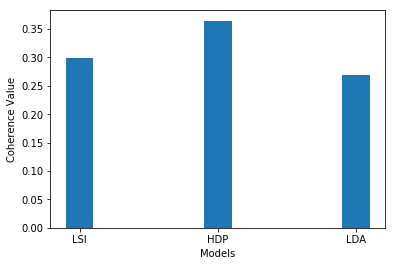

In [180]:
import matplotlib.pyplot as plt
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

In [181]:
lda_model_filepath = os.path.join(data_directory, 'lda_model_all')

In [182]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the LDA model yourself.
if True:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=5,
                           id2word=trigram_dictionary,
                           workers=3)
    
    lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

CPU times: user 1.19 s, sys: 141 ms, total: 1.33 s
Wall time: 1.46 s


In [183]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [184]:
explore_topic(topic_number=3)

term                 frequency

disability           0.006
death                0.005
die                  0.004
home_care            0.004
child                0.004
hospital             0.003
man                  0.003
preference           0.003
hospice              0.003
worker               0.003
care_recipient       0.003
dementia             0.002
contact              0.002
end_life             0.002
parent               0.002
medicare             0.002
loss                 0.002
provider             0.002
symptom              0.002
elder                0.002
client               0.002
baseline             0.002
retirement           0.002
impairment           0.002
aide                 0.002
